# Results - Anomaly Detection on Synthetic Data
Notice that you have to have results from the notebook `synthetic_anomaly_AB.ipynb` to successfully execute this notebook!

In [1]:
import sys
import os
import time
import glob
from pathlib import Path
import sklearn
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets


# initialize environment, paths, etc...
IN_COLAB = 'google.colab' in sys.modules

if(IN_COLAB):
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    !pip install -r /content/structural_health_monitoring/requirements.txt
    
    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if(pd.__version__ != '1.4.2'):
      print('Stopping RUNTIME! Please run again to finish installation.')
      os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    sys.path.insert(0,"../src")
    
    
sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print('installing zippee-ki-yay...')
    !pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [2]:
from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_metrics_bar,
    get_metrics_summary,
    plot_cv_indices)

# configure fonts, etc...
init_plotting()

from scoring_utils import (
    get_synth_regression_scoring,
    SHM_Scoring)

from bench_utils import extract_metrics

## Loading Results

In [3]:
result_file = "synthetic_anomaly_AB.pkl"
result_file = Path(RESULT_PATH, result_file)

results = pd.read_pickle(result_file)

In [4]:
results.head()

,fit_time,score_time,test_balanced_accuracy,test_roc_auc,test_f1_pos,test_f1_neg,test_recall_pos,test_recall_neg,test_precision_pos,test_precision_neg,test_roc_auc_ovr,test_tn,test_fp,test_fn,test_tp,model
0,0.140623,1.052209,0.974215,0.995839,0.231884,0.994145,0.96,0.988430,0.131868,0.999926,0.974215,26996,316,2,48,IsolationForest_0
1,0.134639,1.000348,0.994123,0.997830,0.237530,0.994089,1.00,0.988247,0.134771,1.000000,0.994123,26991,321,0,50,IsolationForest_0
2,0.139626,1.061186,0.984160,0.992106,0.234450,0.994107,0.98,0.988320,0.133152,0.999963,0.984160,26993,319,1,49,IsolationForest_0
3,0.134635,0.970381,0.984142,0.996345,0.233890,0.994089,0.98,0.988284,0.132791,0.999963,0.984142,26992,320,1,49,IsolationForest_0
4,0.131676,0.949434,0.974508,0.987537,0.241206,0.994441,0.96,0.989016,0.137931,0.999926,0.974508,27012,300,2,48,IsolationForest_0


## Extract and Plot Metrics

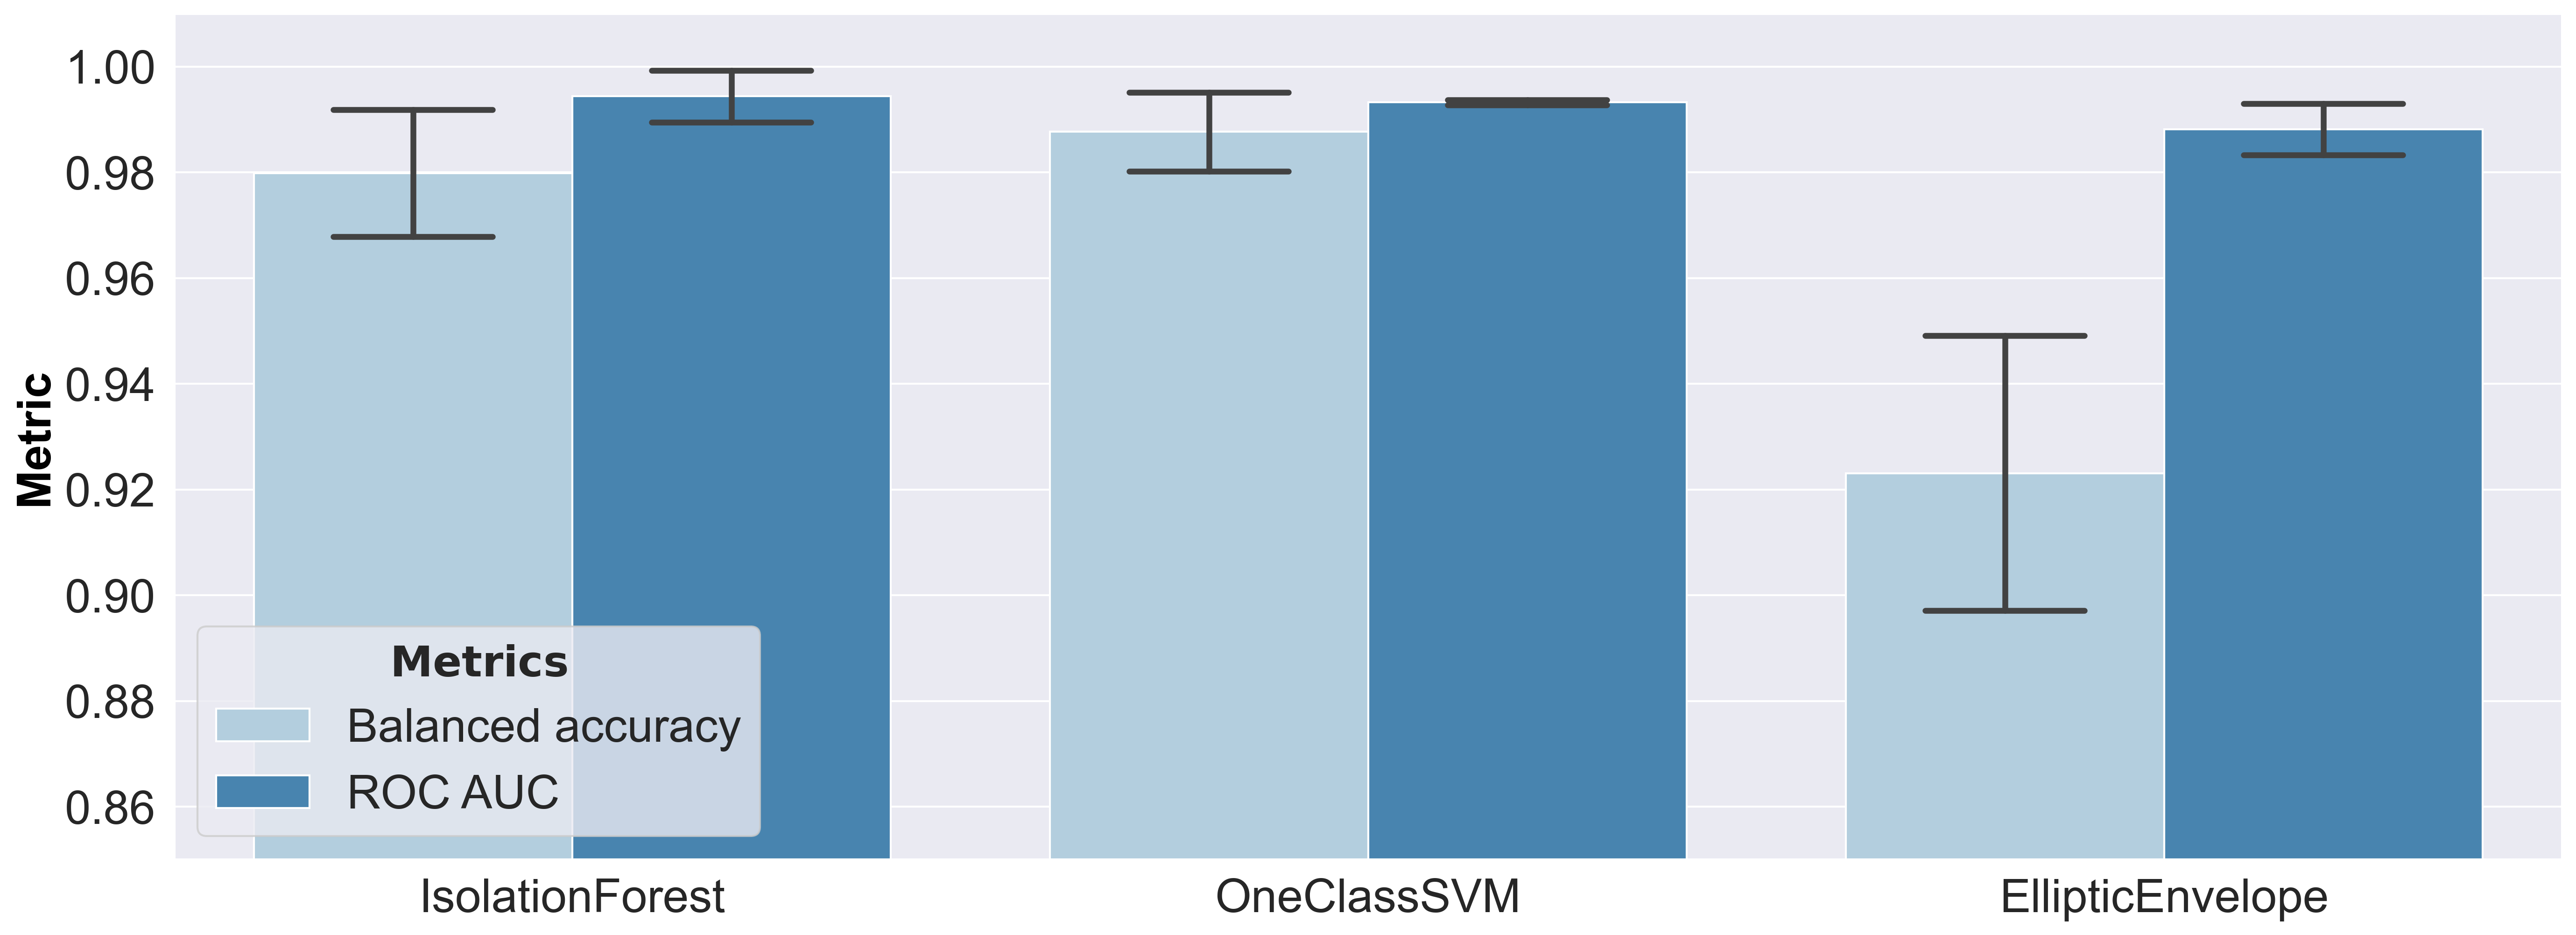

In [5]:
axis_font = {#'family': 'Times',
        'color':  'black',
        'weight': 'bold',
        'size': 24,
        }

fig = plot_metrics_bar(extract_metrics(results,
                                   ['test_balanced_accuracy',
                                    'test_roc_auc']))

plt.ylim([.85, 1.01])
plt.ylabel('Metric', fontdict=axis_font)
plt.xlabel('')

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [item.replace('test_balanced_accuracy',
                           'Balanced accuracy').replace('test_roc_auc',
                                                        'ROC AUC')
              for item in labels]
plt.legend(handles, new_labels, ncol=1, loc='best',
           title="$\\bf{Metrics}$",
           title_fontsize=22)

labels = [item.get_text().replace('_0', '') for item in plt.gca().get_xticklabels()]
plt.gca().set_xticklabels(labels)


fname = Path(RESULT_PATH, r"synth_anomaly_bacc.pdf")
plt.savefig(fname, bbox_inches='tight')
plt.show()

In [6]:
df = extract_metrics(results, ['test_balanced_accuracy'])

get_metrics_summary(df)

,,mean,std
model,metrics,,
EllipticEnvelope_0,test_balanced_accuracy,0.923091,0.026104
IsolationForest_0,test_balanced_accuracy,0.979857,0.012070
OneClassSVM_0,test_balanced_accuracy,0.987679,0.007485


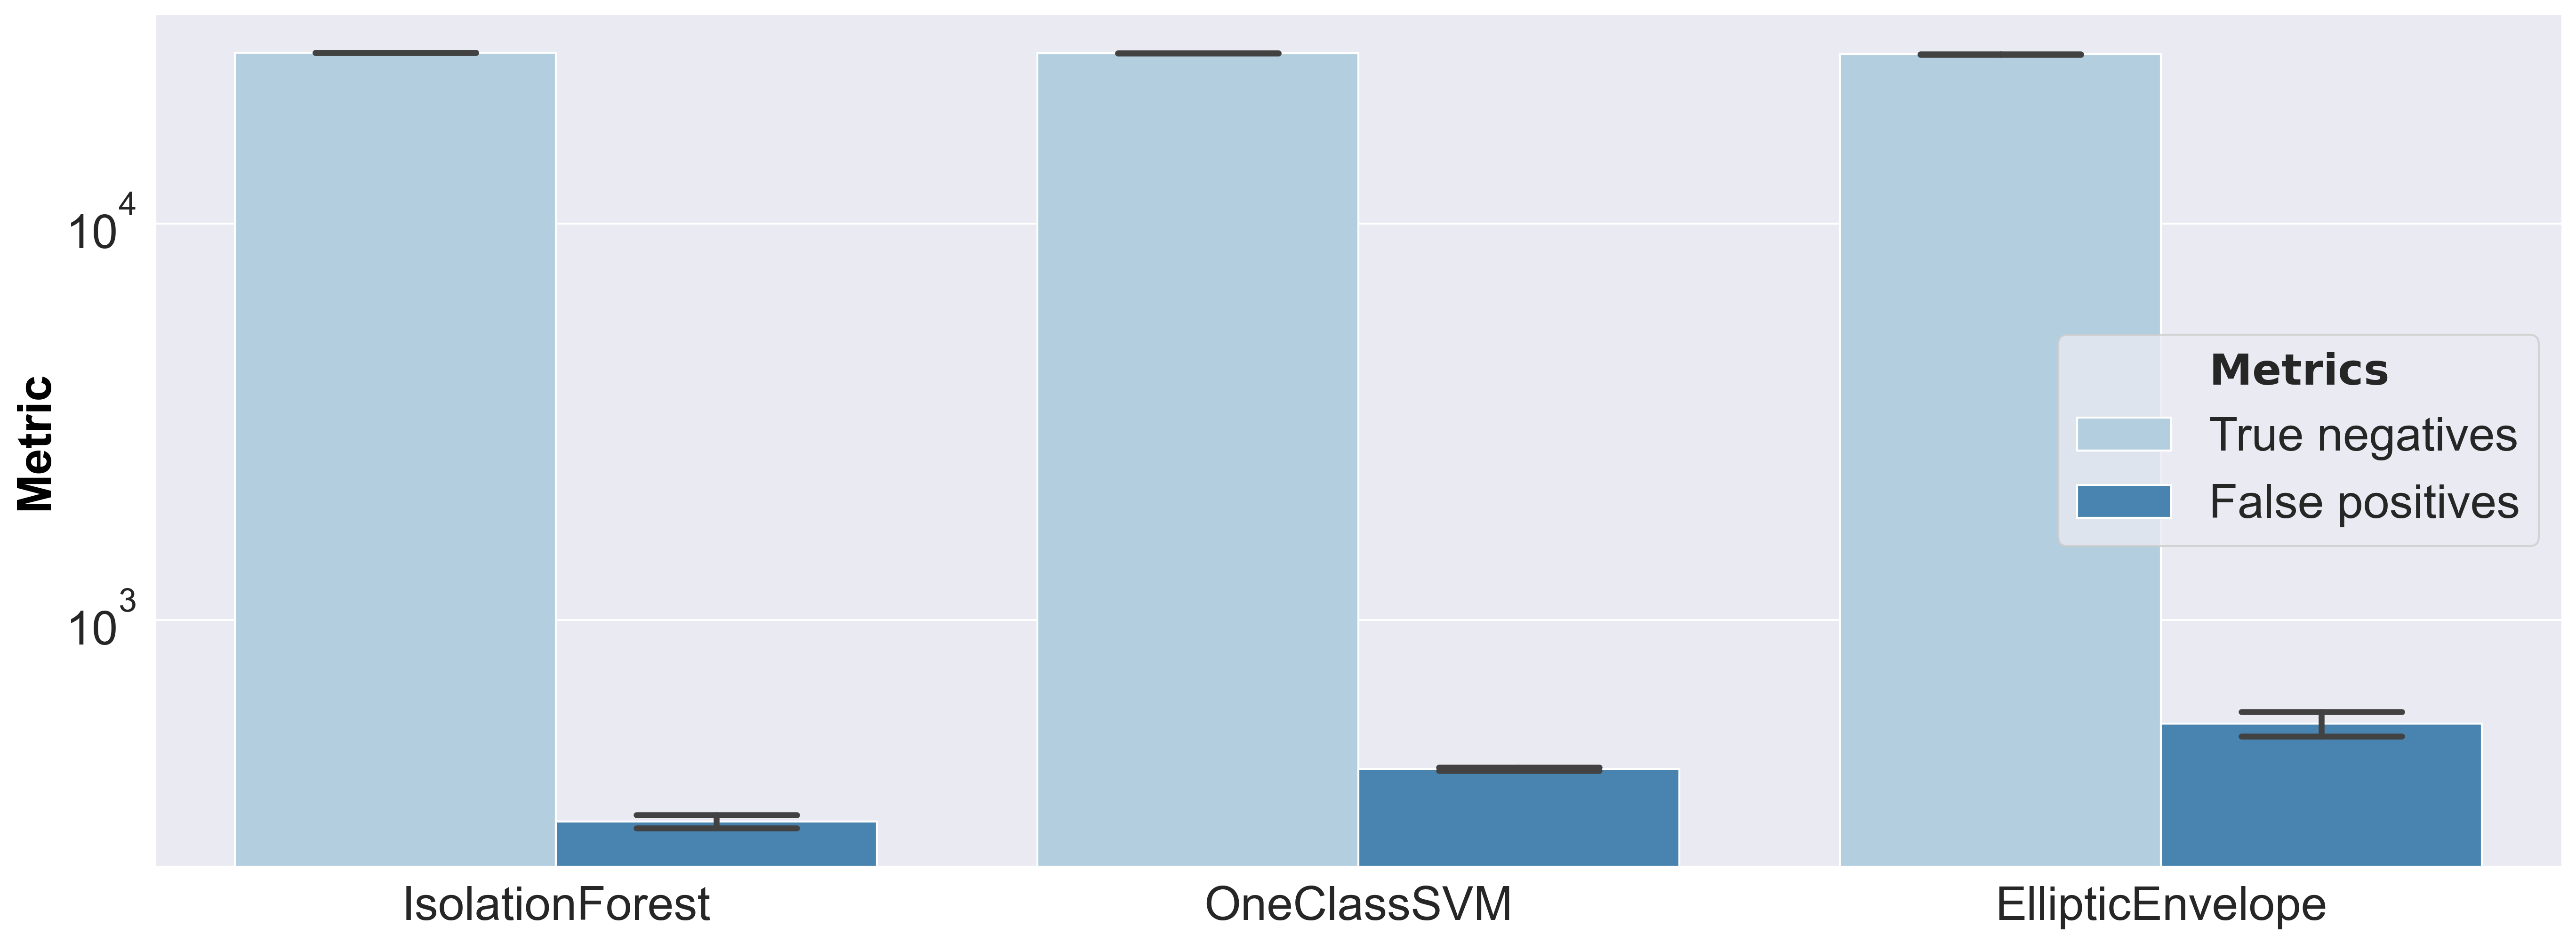

In [7]:
fig = plot_metrics_bar(extract_metrics(results, ['test_fp', 'test_tn']))

plt.yscale("log")
plt.ylabel('Metric', fontdict=axis_font)
plt.xlabel('')
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [item.replace('test_tn',
                           'True negatives').replace('test_fp',
                                                        'False positives')
              for item in labels]
plt.legend(handles, new_labels, ncol=1, loc='best',
           title="$\\bf{Metrics}$",
           title_fontsize=22)

labels = [item.get_text().replace('_0', '') for item in 
          plt.gca().get_xticklabels()]
plt.gca().set_xticklabels(labels)

labels = [item.get_text().replace('_0', '') for item in 
          plt.gca().get_xticklabels()]
plt.gca().set_xticklabels(labels);